In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#import sys
#sys.path.insert(0,'/content/drive/My Drive/AStudyOfASDClassification')

In [4]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, recall_score
scoring = {
    'accuracy':    make_scorer(accuracy_score),
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0)
}

# Load Dataset

In [5]:
from numpy import loadtxt
y_basc444 = loadtxt('Y.csv', delimiter=' ')

In [6]:
import numpy as np
time_series_basc444 = np.load('BASC444.npy', allow_pickle=True)

====================================================================
## Calculate Pearson and Spearman Connectivity
====================================================================

In [7]:
pearson_connectivity = np.zeros((len(time_series_basc444),time_series_basc444[0].shape[1], time_series_basc444[0].shape[1]))
spearman_connectivity = np.zeros((len(time_series_basc444),time_series_basc444[0].shape[1], time_series_basc444[0].shape[1]))

print(pearson_connectivity.shape)
print(spearman_connectivity.shape)

(871, 444, 444)
(871, 444, 444)


In [8]:
time_series_basc444[0].T.shape

(444, 196)

In [9]:
from nilearn.connectome import cov_to_corr
import scipy.stats as stats

for i in range(len(time_series_basc444)):
     cov = np.cov(time_series_basc444[i].T)
     pearson_connectivity[i,:,:] = cov_to_corr(cov)
     rho, pvalue = stats.spearmanr(time_series_basc444[i])
     spearman_connectivity[i,:,:] = rho

In [10]:
pearson_lower = np.zeros((len(time_series_basc444),(444*444-444)//2))
spearman_lower = np.zeros((len(time_series_basc444),(444*444-444)//2))
combine_lower = np.zeros((len(time_series_basc444),pearson_lower.shape[1]+spearman_lower.shape[1]))
print(pearson_lower.shape)
print(spearman_lower.shape)
print(combine_lower.shape)                         

(871, 98346)
(871, 98346)
(871, 196692)


In [11]:
for i in range(pearson_connectivity.shape[0]):
    
    temp = pearson_connectivity[i,:,:]
    v = temp[np.triu_indices(temp.shape[0], k = 1)] 
    pearson_lower[i,:] = v
    
    temp = spearman_connectivity[i,:,:]
    v = temp[np.triu_indices(temp.shape[0], k = 1)] 
    spearman_lower[i,:] = v
    
    combine_lower[i,:] = np.concatenate((pearson_lower[i,:],spearman_lower[i,:]),axis=0)

In [12]:
print(np.isnan(pearson_lower).any())
print(np.isnan(spearman_lower).any())
print(np.isnan(combine_lower).any())

where_are_NaNs = np.isnan(pearson_lower)
pearson_lower[where_are_NaNs] = 0

where_are_NaNs = np.isnan(spearman_lower)
spearman_lower[where_are_NaNs] = 0

where_are_NaNs = np.isnan(combine_lower)
combine_lower[where_are_NaNs] = 0

print(np.isnan(pearson_lower).any())
print(np.isnan(spearman_lower).any())
print(np.isnan(combine_lower).any())


True
True
True
False
False
False


In [13]:
pearson_lower_z = np.arctanh(pearson_lower)
spearman_lower_z = np.arctanh(spearman_lower)

## ================================
## 1. Logistic Regression
## ================================

In [37]:
from sklearn.model_selection import GridSearchCV
gs_lr = GridSearchCV(lr_model, param_grid_lr, cv = 5, verbose = True, n_jobs=-1)
best_lr_train = gs_lr.fit(pearson_lower, y_basc444)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  5.9min finished


In [38]:
best_lr_train.best_estimator_

LogisticRegression(C=0.01, solver='liblinear')

In [80]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
cv = 10
rfe_lr = RFE(LogisticRegression(C=0.01, solver='liblinear'), step = 0.1)
rfe_lr_pipe = Pipeline([('rfe', rfe_lr), ('lr', LogisticRegression(C=0.01, solver='liblinear'))])

# Recompute the cross-validation score
cv_scores_lr = cross_val_score(rfe_lr_pipe, pearson_lower, y_basc444, cv = cv, n_jobs=-1, verbose=1)
classification_accuracy_lr = np.mean(cv_scores_lr)
print("RFE + lr classification accuracy: %.4f" % (classification_accuracy_lr))
# But, be aware that this can take * A WHILE * ...

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:  9.0min remaining:  6.0min


RFE + lr classification accuracy: 0.6900


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 10.6min finished


In [ ]:
# cv = 10
# step = 0.25
# half
# 0.6923

In [ ]:
## 5000  ==> 
## 10000 ==> 0.6314
## 15000 ==> 0.6418
## 20000 ==> 0.6441
## 25000 ==> 0.6429
## 30000 ==> 0.6464
## 35000 ==> 0.6498
## 40000 ==> 0.6406
## 45000 ==> 0.6429
## 50000 ==> 0.6441
## 55000 ==> 0.6452
## 60000 ==> 0.6452
## 65000 ==> 0.6452
## 70000 ==> 0.6452
## 75000 ==> 0.6452
## 80000 ==> 0.6452
## 85000 ==> 0.6452
## 90000 ==> 0.6452
## 95000 ==> 0.6452

In [82]:
lr_pipeline = cross_validate(rfe_lr_pipe, pearson_lower, y_basc444,
                                 cv=cv,  return_estimator = True)

In [95]:
# retrieve the pipeline fitted on the first cross-validation fold and its SVC
# coefficients
lr_pipe = lr_pipeline["estimator"][0]
lr_coef = lr_pipe.named_steps['lr'].coef_
print("After feature selection, the SVC is trained only on {} features".format(
    lr_coef.shape[1]))

# We invert the feature selection step to put these coefs in the right 2D place
full_coef_lr = lr_pipe.named_steps['rfe'].inverse_transform(lr_coef)

print("After inverting feature selection, we have {} features back".format(full_coef_lr.shape[1]))

After feature selection, the SVC is trained only on 49173 features
After inverting feature selection, we have 98346 features back


[NiftiLabelsMasker.inverse_transform] computing image from signals


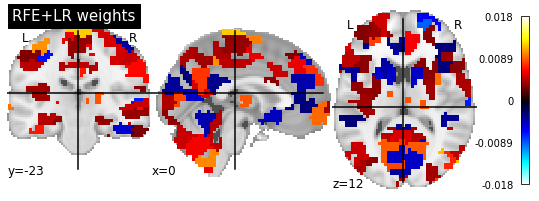

In [126]:
# We apply the inverse of masking on these to make a 4D image that we can plot
from nilearn.plotting import plot_stat_map
weight_img_lr = masker.inverse_transform(full_coef_lr)
plot_stat_map(weight_img_lr, title='RFE+LR weights')

In [84]:
lr_coef.shape

(1, 49173)

In [86]:
lr_coef

array([[ 0.00415024, -0.00343216, -0.00481431, ...,  0.00664225,
        -0.00406406,  0.00699472]])

In [85]:
full_coef_lr.shape

(1, 98346)

In [88]:
# import datasets module and use `fetch_atlas_basc_multiscale_2015` function
from nilearn import datasets
parcellations = datasets.fetch_atlas_basc_multiscale_2015(version='sym')

In [122]:
networks_444 = parcellations['scale444']

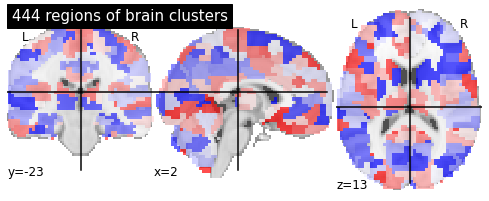

In [123]:
# import plotting module and use `plot_roi` function, since the maps are in 3D
from nilearn import plotting

# The coordinates of all plots are selected automatically by itself
# We manually change the colormap of our choice
plotting.plot_roi(networks_444, cmap=plotting.cm.bwr_r,
                  title='444 regions of brain clusters')

plotting.show()

In [124]:
from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(networks_444,
                           memory='nilearn_cache',
                           memory_level=1,
                           smoothing_fwhm=6,
                           detrend=True,
                           verbose=1)

In [125]:
fmri_masked = masker.fit_transform('Caltech_0051461_func_preproc.nii.gz')

[NiftiLabelsMasker.fit_transform] loading data from /Users/xyang/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale444.nii.gz
Resampling labels


## Linear SVM

In [128]:
from sklearn.svm import LinearSVC
LinearSVC(C=10, random_state=0, tol=1e-05)

LinearSVC(C=10, random_state=0, tol=1e-05)

In [129]:
# Import it and define your fancy objects
from sklearn.feature_selection import RFE

cv = 10

rfe_svc = RFE(LinearSVC(C=10, random_state=0, tol=1e-05),  step=0.1)
rfe = RFE(LinearSVC(C=10, random_state=0, tol=1e-05), step=0.25)

# Create a new pipeline, composing the two classifiers `rfe` and `svc`
rfe_svc_pipe = Pipeline([('rfe', rfe_svc), ('svc', LinearSVC(C=10, random_state=0, tol=1e-05))])

# Recompute the cross-validation score
cv_scores_svc = cross_val_score(rfe_svc_pipe, pearson_lower, y_basc444, cv=cv, n_jobs=-1, verbose=1)
classification_accuracy_svc = np.mean(cv_scores_svc)

print("RFE + lSVM classification accuracy: %.4f" % (classification_accuracy_svc))
# But, be aware that this can take * A WHILE * ...

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed: 64.5min remaining: 43.0min


RFE + lSVM classification accuracy: 0.6716


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 79.6min finished


In [130]:
svc_pipeline = cross_validate(rfe_svc_pipe, pearson_lower, y_basc444,
                                 cv=cv,  return_estimator=True)

After feature selection, the SVC is trained only on 49173 features
After inverting feature selection, we have 98346 features back
[NiftiLabelsMasker.inverse_transform] computing image from signals


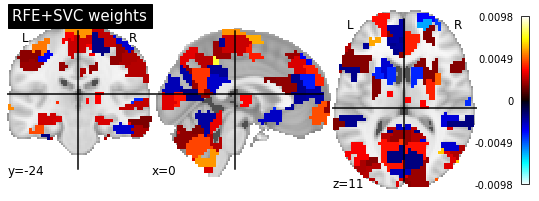

In [131]:
# retrieve the pipeline fitted on the first cross-validation fold and its SVC
# coefficients
rfe_pipe = svc_pipeline["estimator"][0]
svc_coef = rfe_pipe.named_steps['svc'].coef_
print("After feature selection, the SVC is trained only on {} features".format(
    svc_coef.shape[1]))

# We invert the feature selection step to put these coefs in the right 2D place
full_coef_svc = rfe_pipe.named_steps['rfe'].inverse_transform(svc_coef)

print("After inverting feature selection, we have {} features back".format(
    full_coef_svc.shape[1]))

# We apply the inverse of masking on these to make a 4D image that we can plot
from nilearn.plotting import plot_stat_map
weight_img_svc = masker.inverse_transform(full_coef_svc)
plot_stat_map(weight_img_svc, title='RFE+SVC weights')

In [218]:
lsvm_top_five_weights = []
lr_top_five_weights = []

temp_coef_svc = abs(full_coef_svc)
temp_coef_lr = abs(full_coef_lr)

for i in range(5):
    idx_lsvm = np.where(temp_coef_svc[0] == np.max(temp_coef_svc[0]))
    lsvm_top_five_weights.append(int(idx_lsvm[0]))
    temp_coef_svc[0][idx_lsvm] = 0
    
    idx_lr = np.where(temp_coef_lr[0] == np.max(temp_coef_lr[0]))
    lr_top_five_weights.append(int(idx_lr[0]))
    temp_coef_lr[0][idx_lr] = 0

In [222]:
lsvm_top_five_weights

[71206, 18960, 94903, 44203, 18240]

In [223]:
lr_top_five_weights

[69718, 17248, 18240, 71206, 71098]

====================================================================
##  Find the index for the top 5 regions
====================================================================

In [224]:
te = cov_to_corr(np.cov(time_series_basc444[0].T))
print(te.shape)
re = te[np.triu_indices(te.shape[0], k = 1)] 
print(re.shape)
np.triu_indices(te.shape[0], k = 1)

(444, 444)
(98346,)


(array([  0,   0,   0, ..., 441, 441, 442]),
 array([  1,   2,   3, ..., 442, 443, 443]))

In [225]:
## Five Features select using logistric regression with RFE
for i in range(full_coef_lr.shape[1]):
    for j in range(len(lr_top_five_weights)):
        if i == lr_top_five_weights[j]:
            print(str(np.triu_indices(te.shape[0], k = 1)[0][i]) + ' ' + str(np.triu_indices(te.shape[1], k = 1)[1][i]))

40 349
43 138
204 257
210 224
210 332


In [227]:
## Five Features select using logistric regression with RFE
for i in range(full_coef_svc.shape[1]):
    for j in range(len(lsvm_top_five_weights)):
        if i == lsvm_top_five_weights[j]:
            print(str(np.triu_indices(te.shape[0], k = 1)[0][i]) + ' ' + str(np.triu_indices(te.shape[1], k = 1)[1][i]))

43 138
45 61
114 257
210 332
360 404


====================================================================
## 5. Find parcellation cut coords
====================================================================

In [229]:
from nilearn import plotting
coords, labels_list = plotting.find_parcellation_cut_coords(networks_444,return_label_names = True)

In [230]:
coords.shape

(444, 3)

====================================================================
## 6. Use MRIcron to select coordinates
====================================================================

## Top Five Features select using logistric regression with RFE
40 349 <br>
43 138 <Br>
204 257 <br>
210 224 <br>
210 332 <br>

In [293]:
## 1

idx1 = 40
idx2 = 349

ROI1 = [round(a) for a in coords[idx1]]
ROI2 = [round(a) for a in coords[idx2]]

print("Region " + str(idx1) + " : " + str(ROI1) + " = Rectus_L (Frontal Medial Cortex)")
print("Region " + str(idx2) + " : " + str(ROI2) + " = Temporal_Mid_L (Middle Temporal Gyrus)")

Region 40 : [-5, 34, -22] = Rectus_L (Frontal Medial Cortex)
Region 349 : [-63, -35, -12] = Temporal_Mid_L (Middle Temporal Gyrus)


In [294]:
## 2

idx1 = 43
idx2 = 138

ROI1 = [round(a) for a in coords[idx1]]
ROI2 = [round(a) for a in coords[idx2]]

print("Region " + str(idx1) + " : " + str(ROI1) + " = Parietal_Inf_L (Supramarginal Gyrus)")
print("Region " + str(idx2) + " : " + str(ROI2) + " = Frontal_Inf_Tri_R (Middle Frontal Gyrus))")

Region 43 : [-55, -51, 43] = Parietal_Inf_L (Supramarginal Gyrus)
Region 138 : [40, 19, 26] = Frontal_Inf_Tri_R (Middle Frontal Gyrus))


In [295]:
## 3

idx1 = 204
idx2 = 257

ROI1 = [round(a) for a in coords[idx1]]
ROI2 = [round(a) for a in coords[idx2]]

print("Region " + str(idx1) + " : " + str(ROI1) + " = Frontal_Sup_Medial_L (Paracingulate Gyrus)")
print("Region " + str(idx2) + " : " + str(ROI2) + " = Frontal_Med_Orb_L (Frontal Pole)")

Region 204 : [-9, 52, 13] = Frontal_Sup_Medial_L (Paracingulate Gyrus)
Region 257 : [-10, 64, -4] = Frontal_Med_Orb_L (Frontal Pole)


In [296]:
## 4

idx1 = 210
idx2 = 224

ROI1 = [round(a) for a in coords[idx1]]
ROI2 = [round(a) for a in coords[idx2]]

print("Region " + str(idx1) + " : " + str(ROI1) + " = Occipital_Mid_L (Lateral Occipital Cortex)")
print("Region " + str(idx2) + " : " + str(ROI2) + " = Angular_R (Lateral Occipital Cortex)")

Region 210 : [-42, -78, 34] = Occipital_Mid_L (Lateral Occipital Cortex)
Region 224 : [46, -61, 28] = Angular_R (Lateral Occipital Cortex)


In [297]:
## 5

idx1 = 210
idx2 = 332

ROI1 = [round(a) for a in coords[idx1]]
ROI2 = [round(a) for a in coords[idx2]]

print("Region " + str(idx1) + " : " + str(ROI1) + " = Occipital_Mid_L (Lateral Occipital Cortex)")
print("Region " + str(idx2) + " : " + str(ROI2) + " = Temporal_Mid_R (Middle Temporal Gyrus)")

Region 210 : [-42, -78, 34] = Occipital_Mid_L (Lateral Occipital Cortex)
Region 332 : [64, -34, -1] = Temporal_Mid_R (Middle Temporal Gyrus)


## Top Five Features select using linear SVM with RFE

43 138 <br>
45 61 <br>
114 257 <br>
210 332 <br>
360 404 <br>

In [298]:
## 1

idx1 = 43
idx2 = 138

ROI1 = [round(a) for a in coords[idx1]]
ROI2 = [round(a) for a in coords[idx2]]

print("Region " + str(idx1) + " : " + str(ROI1) + " = Parietal_Inf_L (Supramarginal Gyrus)")
print("Region " + str(idx2) + " : " + str(ROI2) + " = Frontal_Inf_Tri_R (Middle Frontal Gyrus)")

Region 43 : [-55, -51, 43] = Parietal_Inf_L (Supramarginal Gyrus)
Region 138 : [40, 19, 26] = Frontal_Inf_Tri_R (Middle Frontal Gyrus)


In [299]:
## 2

idx1 = 45
idx2 = 61

ROI1 = [round(a) for a in coords[idx1]]
ROI2 = [round(a) for a in coords[idx2]]

print("Region " + str(idx1) + " : " + str(ROI1) + " = Cerebelum_B_L")
print("Region " + str(idx2) + " : " + str(ROI2) + " = Temporal_Inf_L (Middle Temporal Gyrus)")

Region 45 : [-40, -54, -53] = Cerebelum_B_L
Region 61 : [-56, -4, -28] = Temporal_Inf_L (Middle Temporal Gyrus)


In [300]:
## 3

idx1 = 114
idx2 = 257

ROI1 = [round(a) for a in coords[idx1]]
ROI2 = [round(a) for a in coords[idx2]]

print("Region " + str(idx1) + " : " + str(ROI1) + " = Frontal_Sup_Medial_L (Frontal Pole)")
print("Region " + str(idx2) + " : " + str(ROI2) + " = Frontal_Med_Orb_L (Frontal Pole)")

Region 114 : [-9, 65, 12] = Frontal_Sup_Medial_L (Frontal Pole)
Region 257 : [-10, 64, -4] = Frontal_Med_Orb_L (Frontal Pole)


In [301]:
## 4

idx1 = 210
idx2 = 332

ROI1 = [round(a) for a in coords[idx1]]
ROI2 = [round(a) for a in coords[idx2]]

print("Region " + str(idx1) + " : " + str(ROI1) + " = Occipital_Mid_L (Lateral Occipital Cortex)")
print("Region " + str(idx2) + " : " + str(ROI2) + " = Temporal_Mid_R (Middle Temporal Gyrus)")

Region 210 : [-42, -78, 34] = Occipital_Mid_L (Lateral Occipital Cortex)
Region 332 : [64, -34, -1] = Temporal_Mid_R (Middle Temporal Gyrus)


In [302]:
## 5

idx1 = 360
idx2 = 404

ROI1 = [round(a) for a in coords[idx1]]
ROI2 = [round(a) for a in coords[idx2]]

print("Region " + str(idx1) + " : " + str(ROI1) + " = Frontal_Inf_Orb_R (Frontal Pole)")
print("Region " + str(idx2) + " : " + str(ROI2) + " = ParaHippocampal_L (Parahippocampal Gyrus)")

Region 360 : [38, 41, -19] = Frontal_Inf_Orb_R (Frontal Pole)
Region 404 : [-25, -6, -31] = ParaHippocampal_L (Parahippocampal Gyrus)
